In [39]:
# imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
# import fasttext as ft # language recognition
from pycountry import languages # to convert language ISO to language name
from collections import Counter # for counting
from spacy_langdetect import LanguageDetector # for language detection

## Approach for classification of news article:
1. Randomly select 1,00,000 samples from the dataset. Detect language of each sample using FastText, get their language codes, and add a new column for language.
2. Work only with English-language samples
3. Create contentList (list of lists), where each list corresponds to a sentence (title + description) of a sample.
4. Create bag-of-words model using CountVectorizer.
5. Compute tfIDF scores for each sample/document.
6. Take the top-5 tokens/words (top-5 highest tfIDF scores) for each document and add to list allkeywords. allkeywords is a list if lists, with each list containing the top-5 keywords of each document/sample.
7. Load Word2Vec model (500-dimension). Tokenize contentList and run the Word2Vec model, thereby creating 500-dimension word-vectors for each token in our vocabulary.
8. Load categories to be used for classification. Tokenize/clean the categories.
9. For each category, calculate the similarity of that category with each keyword of a document using Word2Vec's similarity method, and take the average score. So now, let's say we have 10 categories, then we'll have 10 similarity scores for each group of keywords.
10. Choose the top-2 categories (the top-2 highest similarity scores) as the relevant classified category for each document.

## Optimizations
1. Detect languages (other than English) using fasttext ***Done***
2. Can we detect languages using Spacy? Does it give a boost? (SpaCy small model is 12Mb as compared to FastText's 128Mb) ***Done***
3. Word2Vec similarities do well when the keywords are obviously and strongly relatable to the category. But do not do so well when keywords are ambigious. Therefore, we need better feature extraction to understand vague similarities. Can we tune Word2Vec parameters (dim, iter) for this?
4. Use a combination of 300-d Word2Vec and Word2Vec from scratch. Motivation: since 300-d Word2Vec has been trained on a large set of common words, they are better at similarity for common words.
2. Convert non-English languages to English (using BERT)
3. Can we use knn clustering for this unsupervised classification problem.
4. Can we get one keyword, preferably the subject part-of-speech, for each document, and given our known output categories, somehow link each keyword to a category? ***Done***
5. Is it possible to use the vocab tree generated by word2vec as a decision tree for classification?
6. Display a tSNE plot colour-differentiated by their predicted category ***Done***
7. Create a function to predict new news articles

### LDA
1. One keyword appears in more than one topic, while using LDA. **Expected behaviour**: A keyword must occur in only one topic.
2. Find optimal number of total topics (LDA)
3. Limit number of words per topic (LDA)
4. LDA returns topics containing words within documents. How to link words within topics to its general synonyms?
<br>
<br>
Eg: The following sentence,'Whipping up nationalism has a shelf life: Kamal Nath' contains 89% of the topic:
<br>
<br>
0.015*"back" + 0.015*"fighting" + 0.015*"homemade" + 0.015*"demand" + 0.015*"purifier" + 0.015*"smog" + 0.015*"pakistanis" + 0.015*"shelf" + 0.015*"whipping" + 0.015*"nationalism".
<br>
<br>
Here, the words 'nationalism' and 'shelf' have been picked up. How to link this to 'politics'?

In [46]:
import random

n = 1411104 #number of records in file
s = 80000 #desired sample size
filepath = "D:/Study_Material/Data/Train_data (News data set).csv"
skip = sorted(random.sample(range(n),n-s))
col_names = ['title','link','description','long_description','id']

data = pd.read_csv(filepath,sep='|',index_col=None,names=col_names,skiprows=skip)
data = data.dropna(how='any')
data.head()

,title,link,description,long_description,id
0,"Farhan Akhtar to Ranvir Shorey, B-Town mourns ...",https://timesofindia.indiatimes.com/videos/ent...,The Bollywood fraternity on Friday expressed p...,The Bollywood fraternity on Friday expressed p...,3875
1,ലോകത്തിലെ ഏറ്റവും പ്രായം കൂടിയ കാണ്ടാമൃ​ഗം 'ഫോ...,https://www.malayalamexpress.in/archives/991231/,ടാന്‍സാനിയ: ലോകത്തെ ഏറ്റവും പ്രായമേറിയ കാണ്ടാമ...,"TANZANIA: Fosta, 57, the oldest rhinoceros in ...",6523
2,'Only natural born Indian citizen should becom...,https://m.economictimes.com/news/politics-and-...,Flipboard 'Only natural born Indian citizen sh...,Flipboard 'Only natural born Indian citizen sh...,6895
3,Tamil Nadu schools to reopen on January 4,https://timesofindia.indiatimes.com/city/chenn...,CHENNAI: The government has postponed reopenin...,CHENNAI: The government has postponed reopenin...,204
4,4 killed as under construction tunnel collapse...,https://www.prokerala.com/news/articles/a99240...,Four people have been confirmed dead and two o...,Four people have been confirmed dead and two o...,2059


## Pecularities about the data

1. High number of proper nouns (people, places, brands) in the dataset. Since these proper nouns do not occur too many times, the model must be adept at assigning a relevant class to them.

In [ ]:
#NOT IN USE
#using 1/10th of the dataset
newsData = df[:df.shape[0]//10]
newsData.info()

In [ ]:
#NOT IN USE
#to split dataset range into buckets of equal size (for batch processing to not overwhelm CPU)
total = df.shape[0]
nBuckets = 10
if total % nBuckets != 0:
    remainder = total%nBuckets
    total = total - remainder

limit = total//nBuckets
buckets = []
for i in range(1,nBuckets):
    buckets.append(i*limit)

print(buckets)

In [47]:
#language detection - spacy
def detect_lang_spacy(dataframe, startLimit, endLimit, spacy_object, langs):
    for title in dataframe.title[startLimit:endLimit]:
        title = title.strip()
        title = title.replace('\n','')
        doc = spacy_object(title)
        lout = doc._.language
        detected_lang = lout['language']
        if len(detected_lang) == 2:
            try:
                lang_name = languages.get(alpha_2=detected_lang).name
                print(lang_name)
                langs.append(lang_name)
            except:
                langs.append('New')
        else:
            langs.append('New')
    return langs

In [ ]:
#NOT IN USE
#function to detect language of title and return list of languages using fasttext
def detect_lang_fasttext(dataframe, startLimit, endLimit, langs):
    for title in dataframe.title[startLimit+1:endLimit]:
        title = title.strip()
        title = title.replace('\n','')
        lout = lid_model.predict(title)
        print(lout)
        lstr = ''.join(lout[0])
        detected_lang = lstr.split('__')[-1]
        if len(detected_lang) == 2:
            try:
                lang_name = languages.get(alpha_2=detected_lang).name
                print(lang_name)
                langs.append(lang_name)
            except:
                langs.append('New')
        else:
            langs.append('New')
    return langs

In [ ]:
#NOT IN USE
# initialising FastText model
lid_model = ft.load_model("../input/fasttext-language-prediction/lid.176.bin")

In [48]:
#detecting title language
nlp = en_core_web_sm.load()
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)

langs = []
%time langs = detect_lang_spacy(data, 0, data.shape[0], nlp, langs)

hi
English
Marathi
Telugu
Hindi
English
Hindi
Bengali
Bengali
Malayalam
Marathi
Malayalam
Bengali
English
Marathi
English
English
Kannada
Malayalam
Marathi
Hindi
English
English
Hindi
Bengali
English
Kannada
Hindi
Bengali
Marathi
Malayalam
Hindi
Bengali
Tamil
Tamil
Hindi
Gujarati
Gujarati
English
Malayalam
Malayalam
English
English
Kannada
Bengali
Telugu
Bengali
Gujarati
Tamil
English
Malayalam
English
Hindi
Hindi
Hindi
English
English
Bengali
Bengali
Gujarati
English
Malayalam
English
Hindi
English
Nepali (macrolanguage)
English
English
Bengali
Malayalam
Hindi
Malayalam
Malayalam
English
Hindi
German
English
Telugu
Marathi
English
Malayalam
Urdu
Hindi
Marathi
Marathi
English
Kannada
English
English
English
English
Bengali
Malayalam
English
English
Hindi
English
Hindi
Telugu
Marathi
Malayalam
Kannada
Kannada
Hindi
English
Kannada
English
Malayalam
Hindi
Malayalam
Hindi
Tamil
Malayalam
Hindi
Kannada
English
English
Telugu
Marathi
Telugu
Malayalam
Marathi
English
Kannada
English
Tamil
Te

In [49]:
print(len(langs))

lang_counts = Counter(langs).most_common()
for language,count in lang_counts:
    print(language,count)

73008
English 21227
Hindi 14732
Malayalam 8904
Marathi 5954
Kannada 5306
Tamil 5085
Bengali 4632
Telugu 2572
Gujarati 1620
Urdu 979
Nepali (macrolanguage) 721
Panjabi 667
Indonesian 145
Catalan 57
Tagalog 52
Dutch 49
German 45
French 35
Afrikaans 34
Italian 34
Estonian 31
Swedish 22
Danish 17
Spanish 16
Norwegian 14
Somali 11
Romanian 8
Welsh 7
Croatian 6
Swahili (macrolanguage) 6
Albanian 4
Finnish 4
Portuguese 4
Lithuanian 2
Turkish 2
Persian 2
Slovenian 1
New 1


In [50]:
#adding column 'title_language' to newsData for title language
data['title_language'] = langs
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73008 entries, 0 to 79999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             73008 non-null  object
 1   link              73008 non-null  object
 2   description       73008 non-null  object
 3   long_description  73008 non-null  object
 4   id                73008 non-null  object
 5   title_language    73008 non-null  object
dtypes: object(6)
memory usage: 3.9+ MB
None


In [51]:
#creating list of news content (title + description)

data['content'] = data['title']+' '+data['description']
contents = data.content[data.title_language=='English']
contentList = contents.to_numpy()
print(contentList[0:10])

["Farhan Akhtar to Ranvir Shorey, B-Town mourns Kushal Punjabi's death The Bollywood fraternity on Friday expressed pain and shock on the news of TV actor Kushal Punjabi's untimely death. Kushal committed suicide at his home in Mumbai's Bandra area late on Thursday night..."
 "'Only natural born Indian citizen should become President, VP, Prime Minister' Flipboard 'Only natural born Indian citizen should become President, VP, Prime Minister' Only a natural born citizen of India should be eligible to hold office of President, Vice President and Prime M..."
 'Tamil Nadu schools to reopen on January 4 CHENNAI: The government has postponed reopening of all schools in Tamil Nadu by a day to January 4 (Saturday). Teachers’ associations had approached the government for an extra day leave, saying count...'
 "4 killed as under construction tunnel collapsed in China Four people have been confirmed dead and two others are still trapped as of Tuesday morning after an under construction tunnel col

## Keyword extraction from each title using tf-IDF scores

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(stop_words='english')
word_count_vector=cv.fit_transform(contentList)

#display sample 10 words from vocabulary
list(cv.vocabulary_.keys())[:10]

['farhan',
 'akhtar',
 'ranvir',
 'shorey',
 'town',
 'mourns',
 'kushal',
 'punjabi',
 'death',
 'bollywood']

In [53]:
from sklearn.feature_extraction.text import TfidfTransformer

#calculating IDF scores for each word
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [55]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuple of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [56]:
feature_names=cv.get_feature_names()

#sample test case
doc=contentList[19]

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,5)

# now print the results
print("\n=====Doc=====")
print(doc)
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


=====Doc=====
Darbar movie review: This is what Telugu critics are saying about Rajinikanth film Director AR Murugadoss's movie Darbar has failed to impress the Telugu film critics, as it has garnered mixed review and rating. They say that superstar Rajinikanth carries the movie on his shoulders ...

===Keywords===
darbar 0.361
movie 0.35
critics 0.333
rajinikanth 0.332
telugu 0.287


In [57]:
allkeywords = []
for iterator in range(len(contentList)):
    keywords = []
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([contentList[iterator]]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,5)
    
    keywords = [k for k in keywords]
    print(keywords)
    allkeywords.append(keywords)

jor', 'casualty']
['groom', 'bride', 'lucknow', 'memorable', 'celebrations']
['exhibitions', 'tent', 'sleeps', 'walnuts', 'merchants']
['fewer', 'jobs', 'enterin', 'absorbs', 'typically']
['unnao', 'rape', 'treated', 'doctor', 'victim']
['complicate', 'stagflation', 'warning', 'inflation', 'analysts']
['sale', '22nd', 'cashback', '19th', 'instant']
['disco', 'raja', 'teaser', 'stylishly', 'sci']
['echigo', 'vessel', 'arrives', 'japanese', 'nadu']
['comeback', 'kardashians', 'khloe', 'fangirl', 'bro']
['telegram', 'channel', 'oil', 'edible', 'refined']
['retaliating', 'wha', 'actions', 'jaishankar', 'responded']
['sical', 'yes', 'acquiring', 'logistics', 'jumps']
['wipro', 'neemuchwala', 'unhappy', 'slowly', 'forecast']
['wipro', 'arm', 'fund', 'midstage', '150m']
['jorden', 'foreest', 'viswanathan', 'van', 'anand']
['applications', 'selectors', 'bcci', 'senior', 'invites']
['arm', 'black', 'rameshchandra', 'nadkarni', 'bands']
['goyal', 'piyush', 'jobs', 'commerce', 'million']
['platfo

In [59]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer

#regex for capturing only words
tokenizer = RegexpTokenizer(r'\w+')

#to initialize list of English stop words
en_stop = get_stop_words('en')

#create stemmer
p_stemmer = PorterStemmer()

#list to add tokenized documents to 
texts = []

for i in contentList:
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)
    tokens = [i for i in tokens if len(i)>1] #to remove one-letter characters that are created as a result of tokenization
    stopped_tokens = [i for i in tokens if not i in en_stop]
#     stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    texts.append(stopped_tokens)

print(texts)

rs', 'uttar', 'pradesh', 'will', 'make', 'multiple', 'round', 'rear', 'state', 'regulatory', 'authority', 'rera', 'moving', 'towards', 'court', 'court', 'system', 'registration', 'complaints'], ['jamia', 'protests', 'delhi', 'police', 'release', 'photos', '70', 'people', 'involved', 'anti', 'caa', 'protests', 'near', 'jamia', 'delhi', 'news', 'delhi', 'police', 'release', 'photos', '70', 'people', 'involved', 'anti', 'caa', 'protests', 'near', 'jamia', 'top', 'searches', 'delhi', 'police', 'release', 'photos', '70', 'people', 'involved', 'anti', 'caa', 'protests', 'near', 'jamia', 'pti', 'updated', 'jan', '29'], ['delhi', 'assembly', 'polls', '2020', 'big', 'jolt', 'bjp', 'ec', 'bans', 'anurag', 'thakur', 'days', 'parvesh', 'verma', 'delhi', 'assembly', 'polls', '2020', 'big', 'jolt', 'bjp', 'ec', 'bans', 'anurag', 'thakur', 'days', 'parvesh', 'verma', 'election', 'commission', 'india', 'moment', 'ordered', 'two', 'bjp', 'leaders', 'delhi', 'campaign', 'trail'], ['200', 'chinese', 'exh

## Word2Vec for word embeddings

In [61]:
import gensim
import pickle

#building Word2Vec model
%time w2vmodel = gensim.models.Word2Vec(texts,size=500,window=20,min_count=2,workers=10,iter=10)

#saving the model
filename = 'word2vec_model'
w2vmodel.wv.save(filename)

#TRY IF USING pickle
# filename = 'finalized_model.sav'
# pickle.dump(w2vmodel, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

Wall time: 36.7 s


In [ ]:
#NOT IN USE
import gensim
word2vec_path = "../input/nlpword2vecembeddingspretrained/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [62]:
# read and display categories to be used for classification
cats = pd.read_csv('D:/Study_Material/Data/categories_data.csv')
cats = cats.dropna(how='any')
cats

,level1_categories,level_2_categories,refined_categories
0,Info Tech,Info Tech,Travel & Tourism
1,Travel & Tourism,PaaS,Automobiles & Vehicles
2,Travel,Products,Banking & Finance
3,Vehicles & Parts,SaaS,Others
4,Automobiles,Travel & Tourism,Entertainment
5,Shopping,Air Travel,Food & Dining
6,Banking & Finance,Holiday Packages,Health & Pharmaceutical
7,Others,Hotel,World
8,Career & Job,Tourism,Education
9,Entertainment,Travel Booking Services,Family & Relationships


In [63]:
categories = []
for category in cats.refined_categories:
    category = category.lower()
    category = category.split()
    category = [k for k in category if len(k)>1]
    categories.append(category)

print(categories)

[['travel', 'tourism'], ['automobiles', 'vehicles'], ['banking', 'finance'], ['others'], ['entertainment'], ['food', 'dining'], ['health', 'pharmaceutical'], ['world'], ['education'], ['family', 'relationships'], ['home', 'garden'], ['music', 'audio'], ['news', 'politics'], ['online', 'services'], ['housing'], ['sports', 'games'], ['fmcg'], ['gadgets', 'technology'], ['religion', 'spirituality'], ['air', 'travel']]


In [64]:
allsimilarities = []
for keyword in allkeywords:
    category_similarities = []
    for category in categories:
        similarities=0
        for word in category:
            for key in keyword:
                try:
                    similarities += w2vmodel.wv.similarity(key,word)
                except:
                    similarities += 0
        similarity = similarities/(len(category)*len(keyword))
        category_similarities.append(round(similarity,3))
    allsimilarities.append(category_similarities)

In [65]:
# sample list of similarity values to every category for a news content
print('News keywords: \n',allkeywords[1])
print('\nSimilarities:')
for i in range(len(categories)):
    print(categories[i],': ',allsimilarities[1][i])

News keywords: 
 ['citizen', 'natural', 'born', 'president', 'vp']

Similarities:
['travel', 'tourism'] :  0.248
['automobiles', 'vehicles'] :  -0.017
['banking', 'finance'] :  0.105
['others'] :  0.127
['entertainment'] :  0.083
['food', 'dining'] :  0.137
['health', 'pharmaceutical'] :  0.12
['world'] :  0.148
['education'] :  0.166
['family', 'relationships'] :  0.179
['home', 'garden'] :  0.087
['music', 'audio'] :  0.207
['news', 'politics'] :  0.151
['online', 'services'] :  0.06
['housing'] :  0.125
['sports', 'games'] :  0.033
['fmcg'] :  0.197
['gadgets', 'technology'] :  0.13
['religion', 'spirituality'] :  0.357
['air', 'travel'] :  0.212


In [66]:
category_one = []
category_two = []
similarity_score_one = []
similarity_score_two = []
for i in range(len(allsimilarities)):
    temp = list(allsimilarities[i])
    temp.sort(reverse=True)
    index_one = allsimilarities[i].index(temp[0])
    index_two = allsimilarities[i].index(temp[1])
    if len(categories[index_one])>1:
        category_one.append(categories[index_one][0]+','+categories[index_one][1])
    else:
        category_one.append(categories[index_one][0])
    if len(categories[index_two])>1:
        category_two.append(categories[index_two][0]+','+categories[index_two][1])
    else:
        category_two.append(categories[index_two][0])
    similarity_score_one.append(allsimilarities[i][index_one])
    similarity_score_two.append(allsimilarities[i][index_two])

summary_dict = {'content':contentList,'category one':category_one,'similarity score one':similarity_score_one,'category two':category_two,'similarity score two':similarity_score_two}
summary_df = pd.DataFrame(summary_dict)
summary_df.head(10)

,content,category one,similarity score one,category two,similarity score two
0,"Farhan Akhtar to Ranvir Shorey, B-Town mourns ...",entertainment,0.504,"family,relationships",0.502
1,'Only natural born Indian citizen should becom...,"religion,spirituality",0.357,"travel,tourism",0.248
2,Tamil Nadu schools to reopen on January 4 CHEN...,education,0.401,"health,pharmaceutical",0.351
3,4 killed as under construction tunnel collapse...,"air,travel",0.371,"travel,tourism",0.363
4,Thousands trapped on Australia beach encircled...,others,0.361,"air,travel",0.290
5,"Amazon app quiz January 2, 2020: Get answers t...","gadgets,technology",0.557,"music,audio",0.404
6,Look for midcap stocks that will turn into lar...,fmcg,0.509,"banking,finance",0.448
7,"Buy L&T Finance, price target Rs 130: Kunal Bo...",housing,0.630,fmcg,0.490
8,Wrestle Kingdom 14: Night 1 Predictions ​Night...,others,0.264,"family,relationships",0.241
9,"Before Shatabdi era, businessmen visited railw...","home,garden",0.296,others,0.222


## Smooth Inverse Frequency for sentence vectors

In [ ]:
from collections import Counter
import itertools

#to give frequency of each word in the corpus/document
def map_word_frequency(document):
    return Counter(itertools.chain(*document))

#to return list of sentence vectors
def get_sif_feature_vectors(sentence1, sentence2, word_emb_model=w2vmodel):
    sentence1 = [token for token in sentence1.split() if token in word_emb_model.wv.vocab]
    sentence2 = [token for token in sentence2.split() if token in word_emb_model.wv.vocab]
    print(sentence1)
    print(sentence2)
    docs = [sentence1, sentence2]
    word_counts = map_word_frequency(docs)
    print(word_counts)
    embedding_size = 500 # size of vectore in word embeddings
    a = 0.001
    sentence_set=[]
    for sentence in [sentence1, sentence2]:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        print(sentence_length)
        for word in sentence:
            print(word)
            print(word_counts[word])
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF
            print(a_value)
            vs = np.add(vs, np.multiply(a_value, word_emb_model.wv[word])) # vs += sif * word_vector
        vs = np.divide(vs, sentence_length) # weighted average
        sentence_set.append(vs)
    return sentence_set

## t-SNE for word2vec model visualization

In [67]:
labels = []
tokens = []

for keyword_group in allkeywords:
    for word in keyword_group:
        try:
            tokens.append(w2vmodel.wv[word])
        except:
            tokens.append(np.zeros(500,))
        labels.append(word)

# using only 1000 tokens for tSNE
few_tokens = tokens[:1000]
few_labels = labels[:1000]
print(len(few_tokens))
print(len(few_labels))

1000
1000


In [68]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
%time new_values = tsne_model.fit_transform(few_tokens)

Wall time: 32.7 s


In [70]:
tsne_df = pd.DataFrame(new_values)
tsne_df.columns = ['xaxis','yaxis']
tsne_df['token'] = few_labels

tsne_df['category'] = ''
for ind in tsne_df.index:
    tsne_df['category'][ind] = summary_df.iloc[ind//5]['category one']

display(tsne_df.tail(20))

,xaxis,yaxis,token,category
980,-25.774075,-4.935304,icmai,education
981,-3.060932,23.304749,declared,education
982,-3.099580,22.864202,result,education
983,29.941847,21.975945,december,education
984,-33.538998,-12.897886,examicmai,education
985,-6.109560,-12.378638,fiasco,"sports,games"
986,-8.644726,-29.000664,goa,"sports,games"
987,20.256804,-20.998558,super,"sports,games"
988,7.049559,-11.057228,2015,"sports,games"
989,5.797525,-26.462553,host,"sports,games"


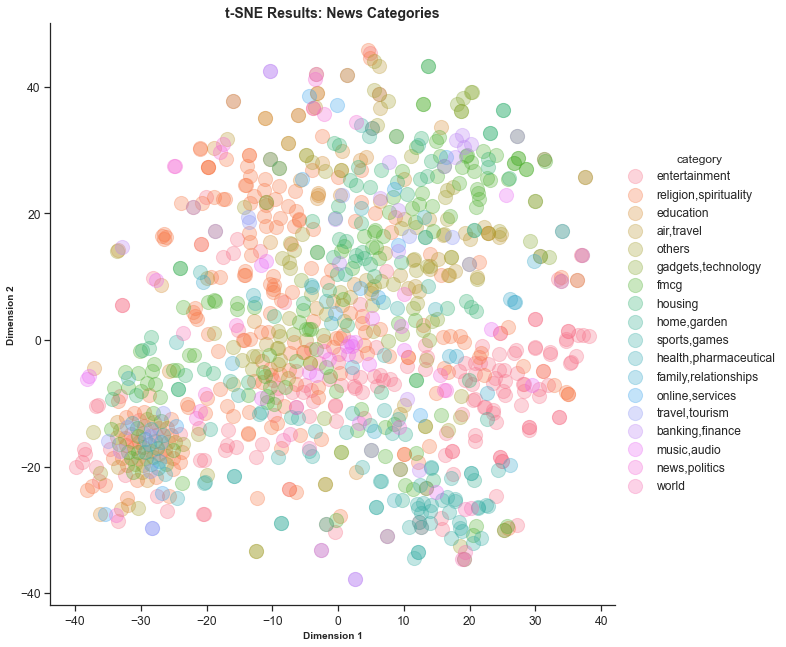

In [72]:
# tSNE plot
import seaborn as sns

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

tsne_plot = sns.lmplot(x='xaxis',
         y='yaxis',
         data=tsne_df,
         legend=True,
         fit_reg=False,
         height=9,
         hue='category',
         scatter_kws={"s":200, "alpha":0.3})
ax = tsne_plot.axes[0,0]

# for line in range(0,tsne_df.shape[0]):
#      ax.text(tsne_df.xaxis[line]+0.4, tsne_df.yaxis[line], tsne_df.token[line], horizontalalignment='left', size='medium', color='black')

plt.title('t-SNE Results: News Categories', weight='bold').set_fontsize('14')
plt.xlabel('Dimension 1', weight='bold').set_fontsize('10')
plt.ylabel('Dimension 2', weight='bold').set_fontsize('10')

In [ ]:
#NOT IN USE
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])
         
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
plt.show()

## Topic Modelling using LDA

In [ ]:
from gensim import corpora,models

#creating dictionary by assigning id to each token in our token list
dictionary = corpora.Dictionary(texts)
print(dictionary.token2id)

In [ ]:
import gensim

#converting our dictionary to bag-of-words model
corpus = [dictionary.doc2bow(text) for text in texts]

#defining number of topics (to be retrived by LDA)
num_topics = 3

#generating LDA model
%time ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, \
                                                 id2word=dictionary, \
                                                 passes=4, \
                                                 eta=2)

In [ ]:
#display results
for i,topic in ldamodel.show_topics(formatted=True, num_topics=num_topics):
    print(str(i)+": \n"+ topic+"\n")

In [ ]:
#printing topics for each document
for i in range(len(corpus)):
    print(ldamodel[corpus[i]])
    print('\n')